In [218]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import cv2
from pathlib import Path
from scipy.interpolate import interp1d
import carla
from scipy.spatial.transform import Rotation as R
import pymap3d as pm

In [219]:
carla_path = Path("./output/pure_carla/carla2k19/Chunk_1/batch1/1")
comma_path = Path("../../datasets/comma2k19/Chunk_1/b0c9d2329ad1606b|2018-07-27--06-50-48/14")


# Comparing processing of positions and orientations

Functions to convert between carla positions and orientations and the comma2k way.

In [220]:
def euler_to_quat(roll, pitch, yaw, deg: bool=False):
    rot = R.from_euler("xyz", (roll, pitch, yaw), degrees=deg)
    # This returns the quaternion on the [x, y, z, w] format
    quat = rot.as_quat()
    x = quat[0]
    y = quat[1]
    z = quat[2]
    w = quat[3]
    return np.array([w, x, y, z])

In [221]:
# HERE: The one currently in use
def euler_to_quaternion2(map: carla.Map, location: carla.Location, rotation: carla.Rotation):
    # alt0 = origin_geolocation.altitude

    # I know this rot matrix works in the original implementation
    # Construct rotation matrix from ECEF to ENU frames
    # https://gssc.esa.int/navipedia/index.php/Transformations_between_ECEF_and_ENU_coordinates
    # r = R.from_matrix([
    #     [-np.sin(lon0),  -np.cos(lon0)*np.sin(lat0),   np.cos(lon0)*np.cos(lat0)],
    #     [np.cos(lon0),   -np.sin(lon0)*np.sin(lat0),   np.sin(lon0)*np.cos(lat0)],
    #     [0,               np.cos(lat0),                np.sin(lat0)             ]]).inv()

    # I think we should remove .inv() because I think original example was from ECEF to ENU
    # https://carla.readthedocs.io/en/latest/python_api/#carlarotation
    # https://se.mathworks.com/help/uav/ug/coordinate-systems-for-unreal-engine-simulation-in-uav-toolbox.html
    # In carla
    # pitch is right-handed rotation around the y-axis [-90, 90]
    # yaw is rotation around the z-axis [-180, 180]
    # roll is rotation around the x-axis [-180, 180]
    # To adjust for the difference in coordinate systems, we need to negate pitch and yaw
    # NOT CORRECT: Adding 180 to convert from values [-180, 180] to [0, 360]
    x = np.radians(rotation.roll)
    y = -(np.radians(rotation.pitch) + np.pi)
    z = -(np.radians(rotation.yaw) + np.pi)
    
    # x = np.radians(rotation.roll)
    # y = np.radians(rotation.pitch)
    # z = np.radians(rotation.yaw)
    carla_rot = R.from_euler("xyz", (x, y, z), degrees=False)
    # r_z_carla_to_enu = R.from_matrix([
    #     [np.cos(z), -np.sin(z), 0],
    #     [np.sin(z), np.cos(z), 0],
    #     [0, 0, 1]
    # ])

    # r_y_neg_carla_to_enu = R.from_matrix([
    #         [np.cos(-y), 0, np.sin(-y)],
    #         [0, 1, 0],
    #         [-np.sin(-y), 0, np.cos(-y)]
    #     ])

    # r_x_carla_to_enu = R.from_matrix([
    #         [1, 0, 0],
    #         [0, np.cos(x), -np.sin(x)],
    #         [0, np.sin(x), np.cos(x)]
    #     ])

    # Additional rotation matrix to align Unreal Engine's coordinate system with ENU
    # To make them compatible, we force the Unreal coordinate space to be aligned with the ENU space
    # Then x and y is swapped (but have the same rotation sign) and z is negated
    # R_align = R.from_matrix([
    #     [0, 1, 0],
    #     [1, 0, 0],
    #     [0, 0, -1]
    # ])


    # r_carla_to_ecef =  R_align #* r_z_carla_to_enu * r_y_neg_carla_to_enu * r_x_carla_to_enu
    # enu_rot = r_carla_to_ecef * carla_rot
    enu_rot = carla_rot
    # Rotate the rotation to ENU
    

    # x, y = y, x
    # z = -z
    # We have that in CARLA
    # yaw [-180, 180]  YES
    # roll [-180, 180] ALL VALUES ARE AROUND 0
    # pitch [-90, 90] YES
    
    # NEW HERE  
    # OLD HERE
    origin_geolocation = map.transform_to_geolocation(carla.Location(0, 0, 0)) 
    # print("origin_geolocation = ", origin_geolocation.latitude, origin_geolocation.longitude, origin_geolocation.altitude)
    lat0 = np.radians(origin_geolocation.latitude)
    lon0 = np.radians(origin_geolocation.longitude)
    r_enu_to_ecef = R.from_matrix(
        [
            [-np.sin(lon0), -np.cos(lon0) * np.sin(lat0), np.cos(lon0) * np.cos(lat0)],
            [np.cos(lon0), -np.sin(lon0) * np.sin(lat0), np.sin(lon0) * np.cos(lat0)],
            [0, np.cos(lat0), np.sin(lat0)],
        ]
    )

    # enu_rot = R.from_euler("xyz", (x, y, z), degrees=False)
    ecef_rot = r_enu_to_ecef * enu_rot
    # This returns the quaternion on the [x, y, z, w] format
    ecef_orientation = ecef_rot.as_quat()
    x = ecef_orientation[0]
    y = ecef_orientation[1]
    z = ecef_orientation[2]
    w = ecef_orientation[3]

    # print(f"{ecef_orientation = }")
    return np.array([w, x, y, z])

# HERE: The one currently in use
def carla_location_to_ecef(map: carla.Map, location: carla.Location):
    # I want to check if this finds the origin
    origin_geolocation = map.transform_to_geolocation(carla.Location(0, 0, 0)) 
    # geolocation = map.transform_to_geolocation(location)
    # https://docs.unrealengine.com/4.27/en-US/BuildingWorlds/Georeferencing/
    e_enu = location.x  # meters
    n_enu = -location.y  # Negate y to convert from right-handed to left-handed coordinate system
    # n_enu = location.y
    u_enu = location.z

    x, y, z = pm.enu2ecef(
        e_enu,
        n_enu, 
        u_enu,
        np.radians(origin_geolocation.latitude),
        np.radians(origin_geolocation.longitude),
        origin_geolocation.altitude,
        deg=False,
    )
    # latitude = geolocation.latitude
    # longitude = geolocation.longitude
    # altitude = geolocation.altitude

    return np.array([x, y, z])

once = False
def print_once(string):
    global once
    if not once:
        print(string)
        once = True

def carla_location_to_ecef2(map: carla.Map, location: carla.Location):
    origin_geolocation = map.transform_to_geolocation(carla.Location(0, 0, 0))
    lat0 = np.radians(origin_geolocation.latitude)
    lon0 = np.radians(origin_geolocation.longitude)
    alt0 = origin_geolocation.altitude
    x0, y0, z0 = pm.geodetic2ecef(lat0, lon0, alt0, deg=False)
    r = R.from_matrix(
        [
            [-np.sin(lon0), -np.cos(lon0) * np.sin(lat0), np.cos(lon0) * np.cos(lat0)],
            [np.cos(lon0), -np.sin(lon0) * np.sin(lat0), np.sin(lon0) * np.cos(lat0)],
            [0, np.cos(lat0), np.sin(lat0)],
        ]
    )
    enu_pos = np.array([location.x, -location.y, location.z])
    ecef_pos = r.as_matrix() @ enu_pos + (x0, y0, z0)
    print_once(f"{ecef_pos = }")
    return ecef_pos


Functions used to process positions and orientations in the comma2k dataset to plot the trajectory of the vehicle.

In [222]:
def quat2rot(quats):
  quats = np.array(quats)
  input_shape = quats.shape
  quats = np.atleast_2d(quats)
  Rs = np.zeros((quats.shape[0], 3, 3))
  q0 = quats[:, 0]
  q1 = quats[:, 1]
  q2 = quats[:, 2]
  q3 = quats[:, 3]
  Rs[:, 0, 0] = q0 * q0 + q1 * q1 - q2 * q2 - q3 * q3
  Rs[:, 0, 1] = 2 * (q1 * q2 - q0 * q3)
  Rs[:, 0, 2] = 2 * (q0 * q2 + q1 * q3)
  Rs[:, 1, 0] = 2 * (q1 * q2 + q0 * q3)
  Rs[:, 1, 1] = q0 * q0 - q1 * q1 + q2 * q2 - q3 * q3
  Rs[:, 1, 2] = 2 * (q2 * q3 - q0 * q1)
  Rs[:, 2, 0] = 2 * (q1 * q3 - q0 * q2)
  Rs[:, 2, 1] = 2 * (q0 * q1 + q2 * q3)
  Rs[:, 2, 2] = q0 * q0 - q1 * q1 - q2 * q2 + q3 * q3

  if len(input_shape) < 2:
    return Rs[0]
  else:
    return Rs
T_ANCHORS = np.array(
        (
            0.0,
            0.00976562,
            0.0390625,
            0.08789062,
            0.15625,
            0.24414062,
            0.3515625,
            0.47851562,
            0.625,
            0.79101562,
            0.9765625,
            1.18164062,
            1.40625,
            1.65039062,
            1.9140625,
            2.19726562,
            2.5,
            2.82226562,
            3.1640625,
            3.52539062,
            3.90625,
            4.30664062,
            4.7265625,
            5.16601562,
            5.625,
            6.10351562,
            6.6015625,
            7.11914062,
            7.65625,
            8.21289062,
            8.7890625,
            9.38476562,
            10.0,
        )
    )

print("T_ANCHORS.size", T_ANCHORS.size)
def process_pose(frame_positions_in, frame_orientations_in, seq_length):
    num_pts = 10 * 20  # 10 s * 20 Hz = 200 frames DONT CHANGE
    fix_seq_length = seq_length - num_pts - 1  # Is 800 when not in demo
    seq_start_idx = seq_length - (fix_seq_length + num_pts)
    seq_start_idx = np.random.randint(1, seq_start_idx + 1)
    seq_end_idx = seq_start_idx + fix_seq_length
    frame_positions = frame_positions_in[seq_start_idx : seq_end_idx + num_pts]
    frame_orientations = frame_orientations_in[seq_start_idx : seq_end_idx + num_pts]
    t_anchors = T_ANCHORS
    t_idx = np.linspace(0, 10, num=num_pts)

    future_poses = []
    for i in range(fix_seq_length):
        # It is using the current rotation as reference
        ecef_from_local = quat2rot(frame_orientations[i])
        local_from_ecef = ecef_from_local.T
        print(f"{local_from_ecef = }")
        frame_positions_local = np.einsum(
            "ij,kj->ki", local_from_ecef, frame_positions - frame_positions[i]  # remove local_from_ecef[i]
        ).astype(np.float32)

        # Time-Anchor like OpenPilot
        fs = [
            interp1d(t_idx, frame_positions_local[i : i + num_pts, j])
            for j in range(3)
        ]
        interp_positions = [fs[j](t_anchors)[:, None] for j in range(3)]
        interp_positions = np.concatenate(interp_positions, axis=1)

        future_poses.append(interp_positions)
    future_poses = torch.tensor(np.array(future_poses), dtype=torch.float32)
    return future_poses

T_ANCHORS.size 33


In [223]:
seq_length = 1200

In [224]:
def plot_trajectory(poses, index=0):
    poses = poses[index]
    plot_args = dict(label="gt", alpha=1, linewidth=2)
    plt.plot(poses[:, 1], poses[:, 0], "o-", **plot_args)
    plt.xlim((-30, 30))
    plt.ylim((-100, 200))
    plt.show()

In [225]:
def load_video_images(path: str):
    frames = []
    video = cv2.VideoCapture(path)
    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break
        frames.append(frame)
    return frames



# CARLA

In [226]:
# These are original carla positions and orientations in their own coordinate system
plt.ioff()
carla_positions_np = np.load(carla_path / "global_pose/frame_positions")
carla_orientations_np = np.load(carla_path / "global_pose/frame_orientations")
carla_positions = [carla.Location(pos[0], pos[1], pos[2]) for pos in carla_positions_np]
carla_orientations = [carla.Rotation(pos[0], pos[1], pos[2]) for pos in carla_orientations_np]

def load_carla_map():
    with open("/home/ulrikro/code/Carla2/CARLA_0.9.15/CarlaUE4/Content/Carla/Maps/OpenDrive/Town01.xodr", "r") as file:
        data = file.read()
        return carla.Map("Town01", data)

carla_map = load_carla_map()
carla_ecef_pos = np.array([carla_location_to_ecef(carla_map, pos) for pos in carla_positions])
carla_ecef_rot = np.array([euler_to_quaternion2(carla_map, pos, rot) for pos, rot in zip(carla_positions, carla_orientations)])
print("carla_ecef_pos.shape", carla_ecef_pos.shape)
print("carla_ecef_rot.shape", carla_ecef_rot.shape)

carla_ecef_pos.shape (1200, 3)
carla_ecef_rot.shape (1200, 4)


In [227]:
df = pd.DataFrame(carla_orientations_np, columns=["pitch", "yaw", "roll"])
df.describe()

,pitch,yaw,roll
count,1200.000000,1200.000000,1200.000000
mean,-0.001700,-128.505952,-0.009996
std,0.026147,76.335776,0.083012
min,-0.216947,-179.984848,-0.432556
25%,-0.005042,-179.951508,-0.000061
50%,-0.000061,-179.749481,-0.000061
75%,0.000096,-89.957579,-0.000061
max,0.098225,179.932022,0.346678


In [228]:
np.set_printoptions(suppress=True, precision=5)
carla_ecef_rot[0:5]

array([[-0.01289, -0.70638,  0.01279,  0.7076 ],
       [-0.0006 , -0.70712,  0.00097,  0.7071 ],
       [-0.0012 , -0.70712,  0.00193,  0.70709],
       [-0.0018 , -0.70713,  0.0029 ,  0.70707],
       [-0.00239, -0.70714,  0.00386,  0.70706]])

In [229]:
# Process carla poses
carla_future_poses = process_pose(carla_ecef_pos, carla_ecef_rot, seq_length)
carla_future_poses.size()

local_from_ecef = array([[ 0.00003, -0.00221, -1.     ],
       [-0.00052, -1.     ,  0.00221],
       [-1.     ,  0.00052, -0.00003]])
local_from_ecef = array([[ 0.00005, -0.00443, -0.99999],
       [-0.00104, -0.99999,  0.00443],
       [-1.     ,  0.00104, -0.00006]])
local_from_ecef = array([[ 0.00008, -0.00664, -0.99998],
       [-0.00156, -0.99998,  0.00664],
       [-1.     ,  0.00156, -0.00009]])
local_from_ecef = array([[ 0.00011, -0.00885, -0.99996],
       [-0.00208, -0.99996,  0.00885],
       [-1.     ,  0.00208, -0.00013]])
local_from_ecef = array([[-0.00028, -0.0097 , -0.99995],
       [-0.0007 , -0.99995,  0.0097 ],
       [-1.     ,  0.0007 ,  0.00028]])
local_from_ecef = array([[-0.00081, -0.00952, -0.99995],
       [-0.00033, -0.99995,  0.00952],
       [-1.     ,  0.00033,  0.0008 ]])
local_from_ecef = array([[-0.00116, -0.00931, -0.99996],
       [-0.00022, -0.99996,  0.00931],
       [-1.     ,  0.00023,  0.00116]])
local_from_ecef = array([[-0.00137, -0.00912, -0

local_from_ecef = array([[ 0.00013, -0.99987,  0.01631],
       [ 0.00002,  0.01631,  0.99987],
       [-1.     , -0.00013,  0.00002]])
local_from_ecef = array([[ 0.00013, -0.99986,  0.01683],
       [ 0.00002,  0.01683,  0.99986],
       [-1.     , -0.00013,  0.00002]])
local_from_ecef = array([[ 0.00013, -0.99985,  0.01721],
       [ 0.00002,  0.01721,  0.99985],
       [-1.     , -0.00013,  0.00002]])
local_from_ecef = array([[ 0.00013, -0.99984,  0.01765],
       [ 0.00001,  0.01765,  0.99984],
       [-1.     , -0.00013,  0.00002]])
local_from_ecef = array([[ 0.00014, -0.99984,  0.01795],
       [ 0.00001,  0.01795,  0.99984],
       [-1.     , -0.00014,  0.00001]])
local_from_ecef = array([[ 0.00014, -0.99983,  0.01833],
       [ 0.00001,  0.01833,  0.99983],
       [-1.     , -0.00014,  0.00001]])
local_from_ecef = array([[ 0.00013, -0.99983,  0.01856],
       [ 0.00001,  0.01856,  0.99983],
       [-1.     , -0.00013,  0.00001]])
local_from_ecef = array([[ 0.00013, -0.99982,  0

torch.Size([999, 33, 3])

Rotation seem to be very small values in the CARLA dataset... Why?

In [230]:
carla_index = 745  # 30
carla_future_poses[carla_index][[0, 1, 5, 10, 15, 20]].numpy()

array([[ 0.     ,  0.     ,  0.     ],
       [ 0.07918,  0.01166,  0.     ],
       [ 1.89395,  0.51173,  0.00137],
       [ 6.01589,  4.52466,  0.02231],
       [11.27008, 12.78375,  0.06771],
       [18.72299, 24.29528,  0.1308 ]], dtype=float32)

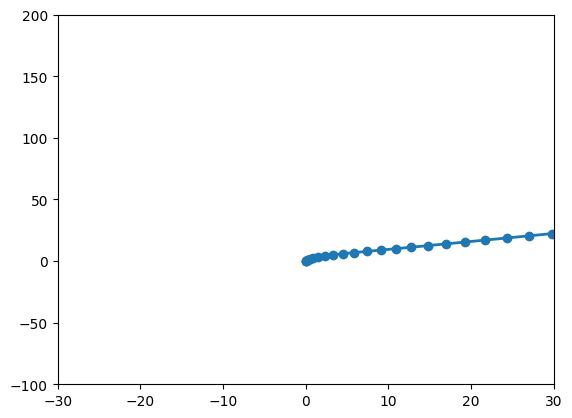

In [231]:
plot_trajectory(carla_future_poses, index=carla_index)

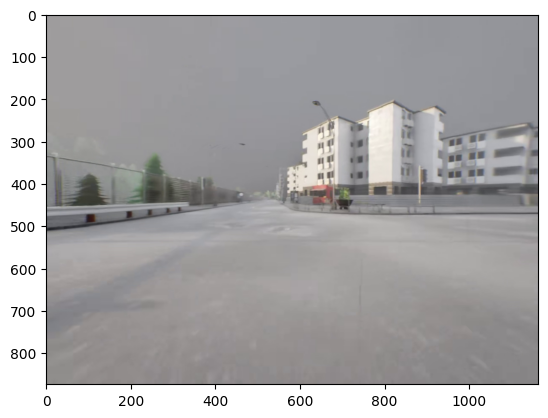

In [232]:
carla_imgs = load_video_images((carla_path / "video.hevc").as_posix())
carla_frame = Image.fromarray(carla_imgs[carla_index][:, :, ::-1])
plt.imshow(np.array(carla_frame))
plt.show()


Here we can see that the coordinates suggests a left turn, but the picture suggests a right turn.

# comma2k19

In [233]:
comma_positions = np.load(comma_path / "global_pose/frame_positions")
# The comma rotations should be global rotations
comma_orientations = np.load(comma_path / "global_pose/frame_orientations")
print("comma_positions.shape", comma_positions.shape)
print("comma_orientations.shape", comma_orientations.shape)


comma_positions.shape (1200, 3)
comma_orientations.shape (1200, 4)


In [234]:
comma_euler = R.from_quat([item[[3, 0, 1, 2]] for item in comma_orientations]).as_euler("xyz", degrees=True)
comma_df = pd.DataFrame(comma_euler, columns=["roll", "pitch", "yaw"])
comma_df.describe()

,roll,pitch,yaw
count,1200.000000,1200.000000,1200.000000
mean,-3.626729,-49.779652,124.949860
std,1.009372,1.640386,1.366005
min,-7.883675,-53.032832,122.877130
25%,-3.888426,-50.576969,123.941255
50%,-3.443872,-49.362037,124.909263
75%,-3.067703,-48.613075,125.460145
max,-1.706521,-47.308963,130.852985


In [235]:
comma_orientations[0:5]

array([[ 0.23005, -0.81196, -0.40265, -0.35449],
       [ 0.23055, -0.81165, -0.40324, -0.35421],
       [ 0.23093, -0.8114 , -0.40382, -0.35389],
       [ 0.23113, -0.81121, -0.40434, -0.35359],
       [ 0.23108, -0.81113, -0.40474, -0.35336]])

In [236]:
# Process comma2k19 poses
comma_future_poses = process_pose(comma_positions, comma_orientations, seq_length)
comma_future_poses.size()

local_from_ecef = array([[ 0.42386,  0.49126,  0.76092],
       [ 0.81791, -0.56848, -0.08859],
       [ 0.38905,  0.65992, -0.64276]])
local_from_ecef = array([[ 0.42338,  0.49187,  0.76079],
       [ 0.81876, -0.56721, -0.08893],
       [ 0.38779,  0.66056, -0.64287]])
local_from_ecef = array([[ 0.42297,  0.49256,  0.76058],
       [ 0.81946, -0.56618, -0.08905],
       [ 0.38676,  0.66093, -0.64311]])
local_from_ecef = array([[ 0.42265,  0.49328,  0.76029],
       [ 0.81989, -0.56558, -0.08884],
       [ 0.38619,  0.6609 , -0.64348]])
local_from_ecef = array([[ 0.42236,  0.49397,  0.76   ],
       [ 0.82011, -0.56536, -0.08831],
       [ 0.38605,  0.66058, -0.64389]])
local_from_ecef = array([[ 0.42203,  0.49473,  0.75969],
       [ 0.82019, -0.56537, -0.08746],
       [ 0.38623,  0.66   , -0.64438]])
local_from_ecef = array([[ 0.4217 ,  0.49542,  0.75942],
       [ 0.82021, -0.56547, -0.08656],
       [ 0.38655,  0.65939, -0.64481]])
local_from_ecef = array([[ 0.42141,  0.49594,  0

torch.Size([999, 33, 3])

In [237]:

comma_index = 740
comma_future_poses[comma_index][[0, 1, 2, 5, 10, 15, 20]].numpy()

array([[ 0.     ,  0.     ,  0.     ],
       [ 0.17433,  0.00247, -0.00838],
       [ 0.69731,  0.00988, -0.03354],
       [ 4.3482 ,  0.05947, -0.22639],
       [17.2945 ,  0.24415, -1.09964],
       [38.45654,  0.69062, -3.26024],
       [67.87021,  1.44354, -6.50245]], dtype=float32)

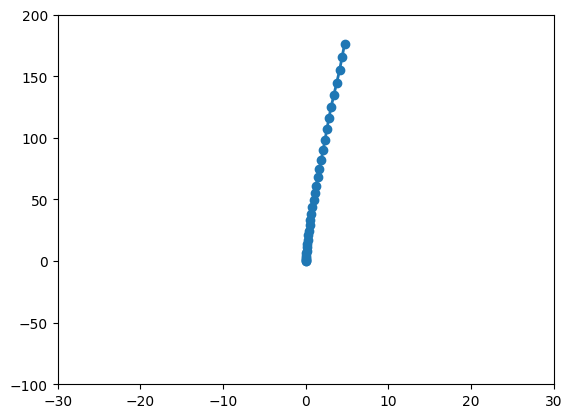

In [238]:
plot_trajectory(comma_future_poses, index=comma_index)

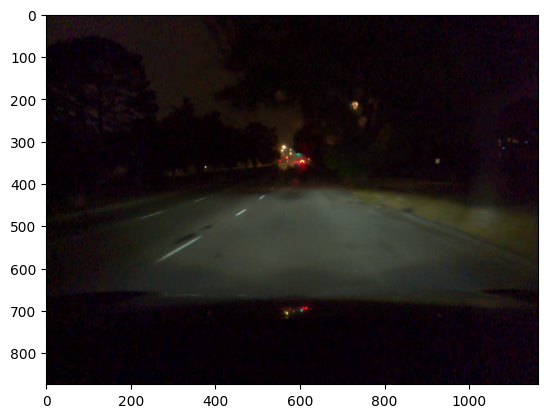

In [239]:
comma_imgs = load_video_images((comma_path / "video.hevc").as_posix())
comma_frame = Image.fromarray(comma_imgs[comma_index][:, :, ::-1])
plt.imshow(np.array(comma_frame))
plt.show()

# Directions in CARLA coordinates
The current problem is that the direction seems to be 180 degrees of what is should be. A turn to the right in the images is plotted as a turn to the left. I want to check if the reason for this is flipped images.

In [240]:
pure_carla_path = Path("./output/pure_carla/carla2k19/Chunk_1/batch1/1/")

In [241]:
pure_carla_positions_np = np.load(carla_path / "global_pose/frame_positions")
pure_carla_orientations_np = np.load(carla_path / "global_pose/frame_orientations")

In [242]:
pure_carla_quats = [euler_to_quat(el[0], el[1], el[2]) for el in pure_carla_orientations_np]

In [243]:
pure_pose = process_pose(pure_carla_positions_np, pure_carla_quats, seq_length)

local_from_ecef = array([[-0.5573 , -0.01662, -0.83014],
       [-0.03103,  0.99952,  0.00082],
       [ 0.82973,  0.02622, -0.55755]])
local_from_ecef = array([[-0.65686, -0.03922, -0.75299],
       [-0.06185,  0.99808,  0.00197],
       [ 0.75147,  0.04786, -0.65802]])
local_from_ecef = array([[-0.74494, -0.06681, -0.66377],
       [-0.09235,  0.99572,  0.00342],
       [ 0.66071,  0.06385, -0.74792]])
local_from_ecef = array([[-0.81998, -0.09826, -0.5639 ],
       [-0.12248,  0.99246,  0.00517],
       [ 0.55914,  0.0733 , -0.82583]])
local_from_ecef = array([[-0.85155, -0.03401, -0.52317],
       [-0.03145,  0.99941, -0.01378],
       [ 0.52333,  0.00471, -0.85212]])
local_from_ecef = array([[-0.84684, -0.01584, -0.53161],
       [ 0.00583,  0.99922, -0.03906],
       [ 0.53181, -0.03618, -0.84609]])
local_from_ecef = array([[-0.84035, -0.01035, -0.54195],
       [ 0.02368,  0.99816, -0.05579],
       [ 0.54153, -0.05972, -0.83856]])
local_from_ecef = array([[-0.83457, -0.00716, -0

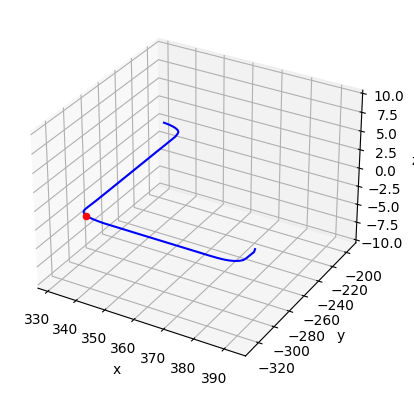

In [244]:
pos = carla_positions_np[2:]
x = [el[0] for el in pos]
# Inverting when plotting
y = [-el[1] for el in pos]
z = [el[2] for el in pos]
ax = plt.axes(projection="3d")
ax.plot3D(x, y, z, "blue")
carla_index = 745
i = carla_index
ax.scatter(x[i], y[i], z[i], color="r")
ax.set_xlabel("x")
ax.set_ylabel("y")
# The z-axis data seems to be quite noisy
ax.set_zlabel("z")
ax.set_zlim(-10, 10)
plt.show()

Here it looks like the car is going left, but from the images it looks like they are going right. Plotting the flipped image to see if it makes sense.

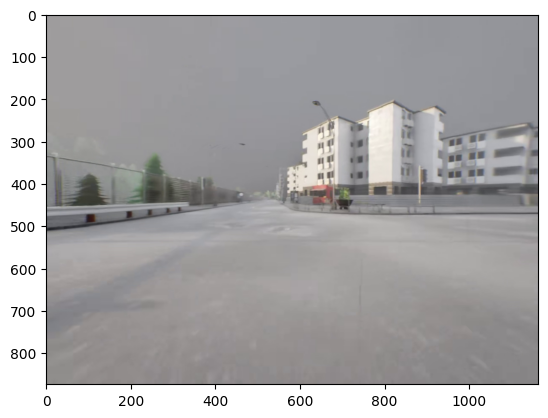

In [245]:
pure_imgs = load_video_images((pure_carla_path / "video.hevc").as_posix())
# FLIPPIN THE IMAGE
pure_frame = Image.fromarray(pure_imgs[carla_index][:, :, ::-1])# .transpose(Image.FLIP_LEFT_RIGHT)
plt.imshow(np.array(pure_frame))
plt.show()

It sort-of makes sense. Is the reason for this flip the inverted y-axis? Will it be wrong to flip the image during saving of the dataset. Need to research this.

# Inversing the pose processing of OP-Deepdive

In [246]:
# Chat-GPT's suggestions
def inverse_process_pose(
    future_poses, initial_frame_position, initial_frame_orientation, seq_length
):
    # GENERATED BY CHATGPT: CAN BE USED AS A STARTING POINT FOR converting waypoints
    num_pts = 10 * 20  # 200 frames
    # fix_seq_length = seq_length - num_pts - 1  # Adjust based on input
    t_anchors = T_ANCHORS  # Time anchors as in the original function
    t_idx = np.linspace(0, 10, num=num_pts)

    reconstructed_positions = []

    for i, waypoint in enumerate(future_poses):
        # Convert the tensor to numpy if it's not already
        if isinstance(waypoint, torch.Tensor):
            waypoint = waypoint.numpy()

        # Reverse the interpolation for each axis
        fs_reversed = [
            interp1d(t_anchors, waypoint[:, j], 
                    # kind="cubic"
                     ) for j in range(3)
        ]
        position_reversed = np.stack([fs_reversed[j](t_idx) for j in range(3)], axis=1)

        # Transform back to the ECEF frame using the inverse rotation
        ecef_from_local = quat2rot(initial_frame_orientation)
        # No transpose?
        position_ecef = (
            np.dot(position_reversed, ecef_from_local) + initial_frame_position
        )

        reconstructed_positions.append(position_ecef)

    return np.array(reconstructed_positions)

## Example from the CARLA original points

From the model output we have the carla points as they are when the are converted to ecef-frd waypoints. The goal is to return the original carla points (both position and orientation) in the CARLA coordinate system. 

In [247]:
# The position ground truth
carla_pos = carla_positions[0]
print(f"{carla_pos.x:.3f}, {carla_pos.y:.3f}, {carla_pos.z:.3f}")

335.428, 274.422, -0.000


In [248]:
# The orientation ground truth
carla_rot = carla_orientations[0]
print(f"{carla_rot.roll:.3f}, {carla_rot.pitch:.3f}, {carla_rot.yaw:.3f}")

-0.010, 0.098, 92.080


In [249]:
# The carla position and rotation as ECEF converted to waypoints
index = 10
carla_future_pose = carla_future_poses[index]
samples = [0, 1, 5, 10, 15, 20]
carla_future_pose[samples].numpy() # sample of the predicted waypoints

array([[ 0.     ,  0.     ,  0.     ],
       [ 0.05812, -0.00004, -0.00083],
       [ 1.56508, -0.00093, -0.01352],
       [ 6.86429,  0.12683, -0.02221],
       [14.96319,  3.68313, -0.02971],
       [16.1593 , 17.18032, -0.03331]], dtype=float32)

In [250]:
# Trying to use the conversion function
pos = inverse_process_pose(carla_future_poses, carla_ecef_pos, carla_ecef_rot, seq_length)

In [251]:

print(pos.shape)
print(pos[index])

(999, 200, 1200, 3)
[[[6378136.99979     335.42807    -274.42181]
  [6378137.28584     392.46024    -308.3804 ]
  [6378137.24718     392.45041    -308.55081]
  ...
  [6378137.00213     331.7785     -195.83821]
  [6378137.00192     331.39194    -195.72795]
  [6378137.00184     331.00043    -195.62857]]

 [[6378137.0034      335.42815    -274.72272]
  [6378137.28997     392.46025    -308.6813 ]
  [6378137.25132     392.45025    -308.85171]
  ...
  [6378137.00088     331.77313    -196.13909]
  [6378137.00078     331.38663    -196.02883]
  [6378137.00082     330.99519    -195.92945]]

 [[6378137.00622     335.42825    -275.03348]
  [6378137.29333     392.46024    -308.99205]
  [6378137.25469     392.45008    -309.16246]
  ...
  [6378136.99992     331.76843    -196.44982]
  [6378136.99989     331.38201    -196.33956]
  [6378137.00003     330.99066    -196.24019]]

 ...

 [[6378135.82527     302.92142    -290.66179]
  [6378137.2485      359.92215    -324.59985]
  [6378137.13831     359.90405

In [252]:
carla_future_poses.shape

torch.Size([999, 33, 3])

In [253]:
# This should equal
print(carla_ecef_pos.shape)
print(carla_ecef_pos[index])

(1200, 3)
[6378136.98171     392.4133     -310.36984]


In [254]:
def direction_to_quaternion(start_point, end_point, up=np.array([0, 0, 1])):
    direction = end_point - start_point
    direction /= np.linalg.norm(direction)  # Normalize

    # Compute right vector as cross product of up and direction
    right = np.cross(up, direction)
    right /= np.linalg.norm(right)

    # Recompute up vector to ensure orthogonality
    up = np.cross(direction, right)
    up /= np.linalg.norm(up)

    # Construct rotation matrix
    rot_matrix = np.vstack([right, up, direction]).T

    # Convert to quaternion
    rot = R.from_matrix(rot_matrix)
    quat = rot.as_quat()  # Returns quaternion as [x, y, z, w]

    return np.array([quat[3], quat[0], quat[1], quat[2]])

In [255]:
def waypoints_to_rotations(waypoints, initial_rotation):
    """
    Estimates the rotations at each waypoint based on the direction of travel.
    
    Parameters:
    - waypoints: A numpy array of shape [N, 2] or [N, 3] representing N waypoints in 2D or 3D space.
    - initial_rotation: The initial rotation as a quaternion [w, x, y, z].
    
    Returns:
    - rotations: A list of quaternions representing the estimated rotation at each waypoint.
    """
    rotations = [initial_rotation]
    for i in range(len(waypoints) - 1):
        # Direction vector from current waypoint to the next
        direction = waypoints[i + 1] - waypoints[i]
        
        # For 2D, calculate yaw as the angle to the horizontal; for 3D, more complex logic would be needed
        yaw = np.arctan2(direction[1], direction[0])
        
        # Convert yaw to a quaternion
        quat = R.from_euler('z', yaw, degrees=False).as_quat()  # Assuming 2D, rotation about Z-axis
        rotations.append(quat)
    
    # Optionally, handle the rotation at the last waypoint (could keep as the same as the second last, or adjust based on context)
    rotations.append(rotations[-1])
    
    return rotations

In [256]:
def estimate_rotation_3d(waypoints, initial_rotation):
    """
    Estimates 3D rotations at each waypoint based on the direction of travel and a fixed up vector.
    
    Parameters:
    - waypoints: A numpy array of shape [N, 3] representing N waypoints in 3D space.
    - initial_rotation: The initial rotation as a quaternion [w, x, y, z].
    
    Returns:
    - rotations: A list of quaternions representing the estimated rotation at each waypoint.
    """
    rotations = [initial_rotation]
    
    # Assume a global up vector
    global_up = np.array([0, 0, 1])
    
    for i in range(len(waypoints) - 1):
        forward = waypoints[i + 1] - waypoints[i]
        forward /= np.linalg.norm(forward)  # Normalize
        
        # Compute the right vector as a cross product of up and forward vectors
        right = np.cross(global_up, forward)
        right /= np.linalg.norm(right)  # Normalize
        
        # Compute the actual up vector as a cross product of forward and right vectors
        up = np.cross(forward, right)
        up /= np.linalg.norm(up)  # Normalize
        
        # Construct a rotation matrix from the right, up, and forward vectors
        rot_matrix = np.vstack([right, up, forward]).T
        
        # Convert the rotation matrix to a quaternion
        quat = R.from_matrix(rot_matrix).as_quat()  # Returns quaternion [x, y, z, w]
        rotations.append([quat[3], quat[0], quat[1], quat[2]])
    
    # Handle the last waypoint by either replicating the last rotation or applying a different logic
    rotations.append(rotations[-1])
    
    return np.array(rotations)

In [257]:
def single_trajectory_to_ecef(future_pose, initial_frame_position, initial_frame_orientation):
    # Ensure the input is a numpy array
    if not isinstance(future_pose, np.ndarray):
        raise ValueError("future_pose must be a numpy array")

    # Check the shape of the future_pose
    if future_pose.shape != (33, 3):
        raise ValueError("future_pose must have shape [33, 3]")
    
    rotations = estimate_rotation_3d(future_pose, initial_frame_orientation)

    # Convert quaternion to rotation matrix
    ecef_from_local = quat2rot(initial_frame_orientation)

    # Using dot multiplication instad of einsum
    # position_ecef = (
    #     np.dot(future_pose, ecef_from_local.T) + initial_frame_position
    # )

    # Correctly apply the rotation matrix to each position in future_pose using Einstein summation
    # This results in a [33, 3] array of rotated positions
    rotated_positions = np.einsum('ij,kj->ki', ecef_from_local, future_pose)

    # Fix for the broadcasting issue:
    # Reshape initial_frame_position to [1, 3] for proper broadcasting when adding to rotated_positions
    initial_frame_position_reshaped = initial_frame_position.reshape(1, 3)

    # Add the reshaped initial frame position to each of the transformed position vectors
    # This operation now correctly broadcasts, adding the initial position to each vector in rotated_positions
    position_ecef = rotated_positions + initial_frame_position_reshaped




    return position_ecef

In [258]:
carla_future_pose

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 5.8116e-02, -3.5178e-05, -8.3279e-04],
        [ 2.3246e-01, -1.4071e-04, -3.3312e-03],
        [ 5.3113e-01, -2.9525e-04, -6.8042e-03],
        [ 9.6756e-01, -5.5423e-04, -1.0448e-02],
        [ 1.5651e+00, -9.3075e-04, -1.3519e-02],
        [ 2.3473e+00, -1.4640e-03, -1.5934e-02],
        [ 3.2918e+00, -1.9284e-04, -1.7909e-02],
        [ 4.3535e+00,  2.3828e-02, -1.9560e-02],
        [ 5.5309e+00,  6.6936e-02, -2.0967e-02],
        [ 6.8643e+00,  1.2683e-01, -2.2212e-02],
        [ 8.3553e+00,  2.0306e-01, -2.3414e-02],
        [ 9.9682e+00,  3.7498e-01, -2.4639e-02],
        [ 1.1718e+01,  8.9113e-01, -2.5916e-02],
        [ 1.3526e+01,  1.9964e+00, -2.7994e-02],
        [ 1.4963e+01,  3.6831e+00, -2.9706e-02],
        [ 1.5814e+01,  5.9221e+00, -3.1107e-02],
        [ 1.6126e+01,  8.4933e+00, -3.2420e-02],
        [ 1.6180e+01,  1.1228e+01, -3.2978e-02],
        [ 1.6171e+01,  1.4130e+01, -3.3111e-02],
        [ 1.6159e+01

In [259]:
ecef_traj = single_trajectory_to_ecef(carla_future_pose.numpy(), carla_ecef_pos[index], carla_ecef_rot[index])

/tmp/ipykernel_219705/4260626624.py:23: RuntimeWarning: invalid value encountered in true_divide
  right /= np.linalg.norm(right)  # Normalize
/tmp/ipykernel_219705/4260626624.py:19: RuntimeWarning: invalid value encountered in true_divide
  forward /= np.linalg.norm(forward)  # Normalize


In [260]:
# This should equal 
carla_ecef_pos[index]

array([6378136.98171,     392.4133 ,    -310.36984])

In [261]:
ecef_traj

array([[6378136.98171,     392.4133 ,    -310.36984],
       [6378136.98247,     392.41282,    -310.42796],
       [6378136.98477,     392.41139,    -310.6023 ],
       [6378136.98789,     392.40891,    -310.90097],
       [6378136.99102,     392.40533,    -311.33738],
       [6378136.99339,     392.40044,    -311.93489],
       [6378136.99489,     392.39408,    -312.71705],
       [6378136.99575,     392.38448,    -313.66157],
       [6378136.99616,     392.35111,    -314.72298],
       [6378136.99618,     392.29763,    -315.89999],
       [6378136.99585,     392.22599,    -317.23277],
       [6378136.9953 ,     392.13662,    -318.72305],
       [6378136.99461,     391.95049,    -320.33436],
       [6378136.99379,     391.41895,    -322.07939],
       [6378136.99365,     390.29777,    -323.87807],
       [6378136.99353,     388.59846,    -325.30002],
       [6378136.99374,     386.35205,    -326.13073],
       [6378136.99447,     383.77825,    -326.41994],
       [6378136.99472,     3

## Converting both position and orientation at the same time

In [274]:
from typing import Optional
def waypoints_to_ecef_with_dynamic_rotations(waypoints, initial_frame_position, initial_frame_orientation):
    # Placeholder for the function to estimate rotations based on direction of travel
    def estimate_rotation_from_direction(current_pos, next_pos, up=np.array([0, 0, 1]), epsilon=1e-6) -> Optional[np.ndarray]:
        forward = next_pos - current_pos
        forward_magnitude = np.linalg.norm(forward)
        
        # Check for near-identical waypoints
        if forward_magnitude < epsilon:
            # Use the last known rotation if waypoints are too close
            return None
        forward /= forward_magnitude
        
        right = np.cross(up, forward)
        right_magnitude = np.linalg.norm(right)
        if right_magnitude < epsilon:
            # Fallback strategy here (e.g., use last valid right or a default)
            return None
        right /= np.linalg.norm(right)
        
        up_corrected = np.cross(forward, right)
        rot_matrix = np.vstack([right, up_corrected, forward])
        
        rotation = R.from_matrix(rot_matrix).as_quat()
        return np.array([rotation[3], rotation[0], rotation[1], rotation[2]])
    
    # Initialize arrays for positions and rotations
    ecef_positions = [initial_frame_position]
    rotations = [initial_frame_orientation]
    
    for i in range(len(waypoints) - 1):
        # Estimate rotation based on the direction of travel
        quat_return = estimate_rotation_from_direction(waypoints[i], waypoints[i + 1])
        quat = quat_return if quat_return is not None else rotations[-1]
        rotations.append(quat)
        
        # Convert the current waypoint to ECEF using the newly estimated rotation
        rot_matrix = quat2rot(quat)
        position_ecef = np.einsum('ij,j->i', rot_matrix, waypoints[i]) + initial_frame_position
        ecef_positions.append(position_ecef)
    
    # Convert lists to numpy arrays for consistency and easier handling
    ecef_positions = np.array(ecef_positions)
    rotations = np.array(rotations)
    
    return ecef_positions, rotations

In [275]:
ecef_pos, ecef_rot = waypoints_to_ecef_with_dynamic_rotations(carla_future_pose.numpy(), carla_ecef_pos[index], carla_ecef_rot[index])

In [276]:
ecef_pos

array([[6378136.98171,     392.4133 ,    -310.36984],
       [6378136.98171,     392.4133 ,    -310.36984],
       [6378136.98171,     392.4133 ,    -310.31172],
       [6378136.98169,     392.41267,    -310.13736],
       [6378136.98173,     392.41093,    -309.83867],
       [6378136.98176,     392.40782,    -309.40224],
       [6378136.98184,     392.40461,    -308.80473],
       [6378136.97709,     392.40227,    -308.02255],
       [6378136.90706,     392.40051,    -307.07883],
       [6378136.84624,     392.39893,    -306.01837],
       [6378136.80039,     392.39749,    -304.84146],
       [6378136.75787,     392.39661,    -303.50802],
       [6378136.29801,     392.39617,    -302.04007],
       [6378134.5209 ,     392.39543,    -300.70288],
       [6378131.63141,     392.39764,    -299.90674],
       [6378127.97963,     392.39325,    -300.07858],
       [6378124.3015 ,     392.38872,    -301.61341],
       [6378121.99621,     392.38614,    -302.58662],
       [6378121.02771,     3

In [283]:
carla_ecef_pos[index + 1]

array([6378136.98662,     392.41092,    -310.65912])

: 